# AÑADIMOS SPARK, LAS LIBRERIAS, Y EL DATASET

In [1]:
!pip install pyspark==3.3.0
import pyspark 
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pyspark-3.3.0-py2.py3-none-any.whl
  Using cached py4j-0.10.9.5-py2.py3-none-any.whl (199 kB)
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.6
    Uninstalling py4j-0.10.6:
      Successfully uninstalled py4j-0.10.6
  Attempting uninstall: pyspark
    Found existing installation: pyspark 2.3.0
    Uninstalling pyspark-2.3.0:
      Successfully uninstalled pyspark-2.3.0


In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from pyspark.ml.feature import Imputer,VectorAssembler
from pyspark.ml.feature import Normalizer
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import ClusteringEvaluator

In [2]:
#Enlace de descarga: https://www.kaggle.com/datasets/harrywang/wine-dataset-for-clustering
from pyspark import SparkFiles
#Leemos el fichero
df=spark.read.csv(SparkFiles.get("/content/wine-clustering.csv"),header=True,inferSchema=True)
print(df)

DataFrame[Alcohol: double, Malic_Acid: double, Ash: double, Ash_Alcanity: double, Magnesium: int, Total_Phenols: double, Flavanoids: double, Nonflavanoid_Phenols: double, Proanthocyanins: double, Color_Intensity: double, Hue: double, OD280: double, Proline: int]


# VISUALIZAMOS LOS DATOS

In [3]:
df.show()

+-------+----------+----+------------+---------+-------------+----------+--------------------+---------------+---------------+----+-----+-------+
|Alcohol|Malic_Acid| Ash|Ash_Alcanity|Magnesium|Total_Phenols|Flavanoids|Nonflavanoid_Phenols|Proanthocyanins|Color_Intensity| Hue|OD280|Proline|
+-------+----------+----+------------+---------+-------------+----------+--------------------+---------------+---------------+----+-----+-------+
|  14.23|      1.71|2.43|        15.6|      127|          2.8|      3.06|                0.28|           2.29|           5.64|1.04| 3.92|   1065|
|   13.2|      1.78|2.14|        11.2|      100|         2.65|      2.76|                0.26|           1.28|           4.38|1.05|  3.4|   1050|
|  13.16|      2.36|2.67|        18.6|      101|          2.8|      3.24|                 0.3|           2.81|           5.68|1.03| 3.17|   1185|
|  14.37|      1.95| 2.5|        16.8|      113|         3.85|      3.49|                0.24|           2.18|            7.

In [4]:
df.summary().show()

+-------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+--------------------+------------------+-----------------+-------------------+------------------+-----------------+
|summary|           Alcohol|        Malic_Acid|               Ash|     Ash_Alcanity|         Magnesium|     Total_Phenols|        Flavanoids|Nonflavanoid_Phenols|   Proanthocyanins|  Color_Intensity|                Hue|             OD280|          Proline|
+-------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+--------------------+------------------+-----------------+-------------------+------------------+-----------------+
|  count|               178|               178|               178|              178|               178|               178|               178|                 178|               178|              178|                178|          

In [5]:
#Miramos la información de las columnas
df.printSchema()

root
 |-- Alcohol: double (nullable = true)
 |-- Malic_Acid: double (nullable = true)
 |-- Ash: double (nullable = true)
 |-- Ash_Alcanity: double (nullable = true)
 |-- Magnesium: integer (nullable = true)
 |-- Total_Phenols: double (nullable = true)
 |-- Flavanoids: double (nullable = true)
 |-- Nonflavanoid_Phenols: double (nullable = true)
 |-- Proanthocyanins: double (nullable = true)
 |-- Color_Intensity: double (nullable = true)
 |-- Hue: double (nullable = true)
 |-- OD280: double (nullable = true)
 |-- Proline: integer (nullable = true)



In [ ]:
#Al ser todos los datos de tipo numerico, no nos hace falta utilizar el metodo StringIndexer

In [6]:
#Miramos cuantos valore NULL/NAN/NONE hay en cada columna
from pyspark.sql.functions import col,isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()
#No encontramos ningun valor nulo en el dataset.

+-------+----------+---+------------+---------+-------------+----------+--------------------+---------------+---------------+---+-----+-------+
|Alcohol|Malic_Acid|Ash|Ash_Alcanity|Magnesium|Total_Phenols|Flavanoids|Nonflavanoid_Phenols|Proanthocyanins|Color_Intensity|Hue|OD280|Proline|
+-------+----------+---+------------+---------+-------------+----------+--------------------+---------------+---------------+---+-----+-------+
|      0|         0|  0|           0|        0|            0|         0|                   0|              0|              0|  0|    0|      0|
+-------+----------+---+------------+---------+-------------+----------+--------------------+---------------+---------------+---+-----+-------+



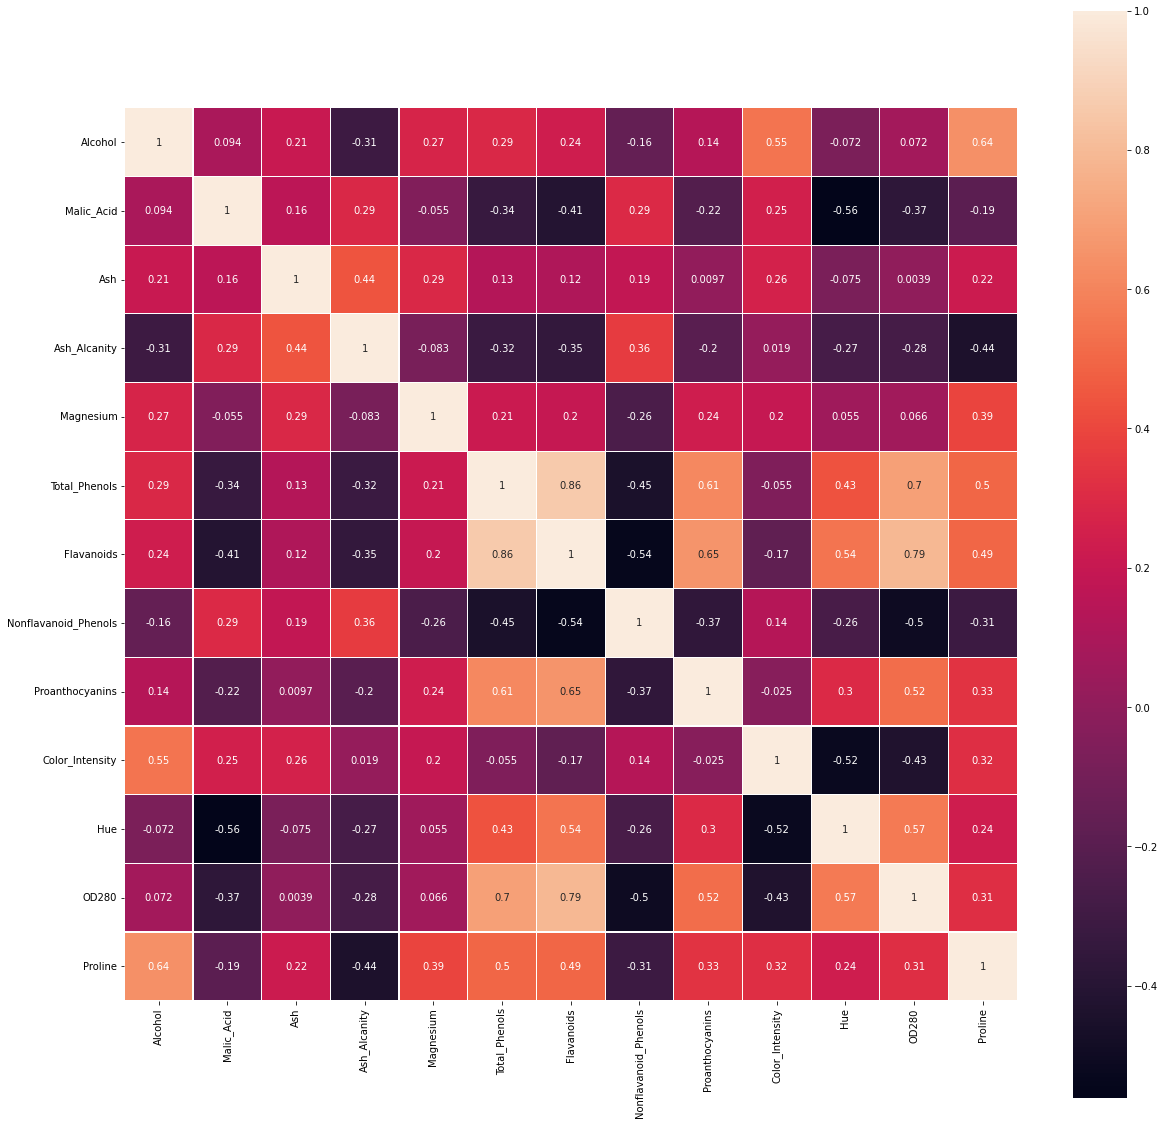

<Figure size 432x288 with 0 Axes>

In [25]:
plt.figure(figsize=(20,20))
sns.heatmap(df.select([c for c in df]).toPandas().corr(),linewidths=0.1,vmax=1.0, square=True, linecolor="white", annot=True)
plt.show()
plt.gcf().clear()

# Podemos ver una fuerte correlación entre Total_Phenols y Flavanoids
# Correlación entre Total_Phenols y OD280
# Correlación entre Flavanoids y OD280

# CREAMOS EL PIPE APLICANDO EL K-MEANS

In [27]:
#Pasamos las columnas a features para trabajar con ML
assembler=VectorAssembler(inputCols=df.columns,outputCol="features")

In [28]:
# Normalizamos los datos por la diferencia de escala de algunas características
normalize = Normalizer(inputCol="features",outputCol="normalFeatures")

### BUSCAMOS EL NÚMERO ÓPTIMO DE K USANDO EL MÉTODO DEL CODO

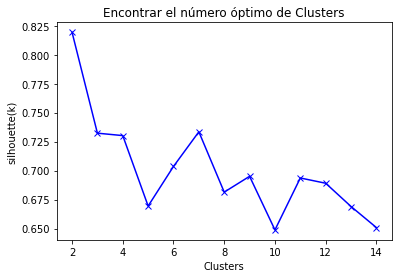

In [37]:
n=range(2,15)
score=[]
for i in n:
  kmeans = KMeans(featuresCol="features", seed=42, k=i,initMode='k-means||',distanceMeasure='euclidean')
  pipeline=Pipeline(stages=[assembler,normalize,kmeans])
  modelo=pipeline.fit(df)
  predictions = modelo.transform(df)
  evaluator = ClusteringEvaluator()
  silhouette = evaluator.evaluate(predictions)
  score.append(silhouette)

plt.plot(n, score, 'bx-')
plt.title("Encontrar el número óptimo de Clusters")
plt.xlabel("Clusters")
plt.ylabel("silhouette(k)")
plt.show()
#Vemos que el mejor k es 2

# APLICAR EL MÉTODO DE K-MEANS

In [38]:
#Creamos el algoritmo de clustering
kmeans = KMeans(featuresCol="features", seed=42, k=2,initMode='k-means||',distanceMeasure='euclidean')

In [39]:
#Realizamos el Pipeline
pipeline=Pipeline(stages=[assembler,normalize,kmeans])
modelo=pipeline.fit(df)

In [40]:
predictions = modelo.transform(df)
predictions.select("prediction", "features").show(5)
predictions.select("prediction").distinct().show()

+----------+--------------------+
|prediction|            features|
+----------+--------------------+
|         1|[14.23,1.71,2.43,...|
|         1|[13.2,1.78,2.14,1...|
|         1|[13.16,2.36,2.67,...|
|         1|[14.37,1.95,2.5,1...|
|         0|[13.24,2.59,2.87,...|
+----------+--------------------+
only showing top 5 rows

+----------+
|prediction|
+----------+
|         1|
|         0|
+----------+



In [41]:
#Mostramos los resultados 
centers = modelo.stages[2].clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)


# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Cluster Centers: 
[1.27065574e+01 2.53360656e+00 2.34024590e+00 2.04237705e+01
 9.66885246e+01 2.06770492e+00 1.64852459e+00 3.93524590e-01
 1.45663934e+00 4.82385245e+00 9.10737705e-01 2.41155738e+00
 5.63500000e+02]
[1.36412500e+01 1.90660714e+00 2.42375000e+00 1.74714286e+01
 1.06392857e+02 2.79053571e+00 2.85875000e+00 2.92857143e-01
 1.88339286e+00 5.56839286e+00 1.05921429e+00 3.04767857e+00
 1.14642857e+03]
Silhouette with squared euclidean distance = 0.8193526758797367


# VISUALIZAMOS LOS RESULTADOS

In [42]:
# Collect Spark DF to Pandas DF
pandasDF = predictions.toPandas()

In [45]:
pandasDF

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,features,normalFeatures,prediction
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,"[14.23, 1.71, 2.43, 15.6, 127.0, 2.8, 3.06, 0....","[0.013264472370098666, 0.0015939738406794601, ...",1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,"[13.2, 1.78, 2.14, 11.2, 100.0, 2.65, 2.76, 0....","[0.01251280047001154, 0.0016873321845924654, 0...",1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,"[13.16, 2.36, 2.67, 18.6, 101.0, 2.8, 3.24, 0....","[0.011063013518360719, 0.0019839446735054177, ...",1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,"[14.37, 1.95, 2.5, 16.8, 113.0, 3.85, 3.49, 0....","[0.009679954833283747, 0.0013135638082744125, ...",1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,"[13.24, 2.59, 2.87, 21.0, 118.0, 2.8, 2.69, 0....","[0.01777498109748654, 0.003477129988103484, 0....",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,"[13.71, 5.65, 2.45, 20.5, 95.0, 1.68, 0.61, 0....","[0.01836445101792137, 0.007568136269238202, 0....",0
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,"[13.4, 3.91, 2.48, 23.0, 102.0, 1.8, 0.75, 0.4...","[0.017691465767898883, 0.005162211280036167, 0...",0
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,"[13.27, 4.28, 2.26, 20.0, 120.0, 1.59, 0.69, 0...","[0.015722744928271155, 0.005071088793745331, 0...",0
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,"[13.17, 2.59, 2.37, 20.0, 120.0, 1.65, 0.68, 0...","[0.015513660573941119, 0.003050902117426537, 0...",0


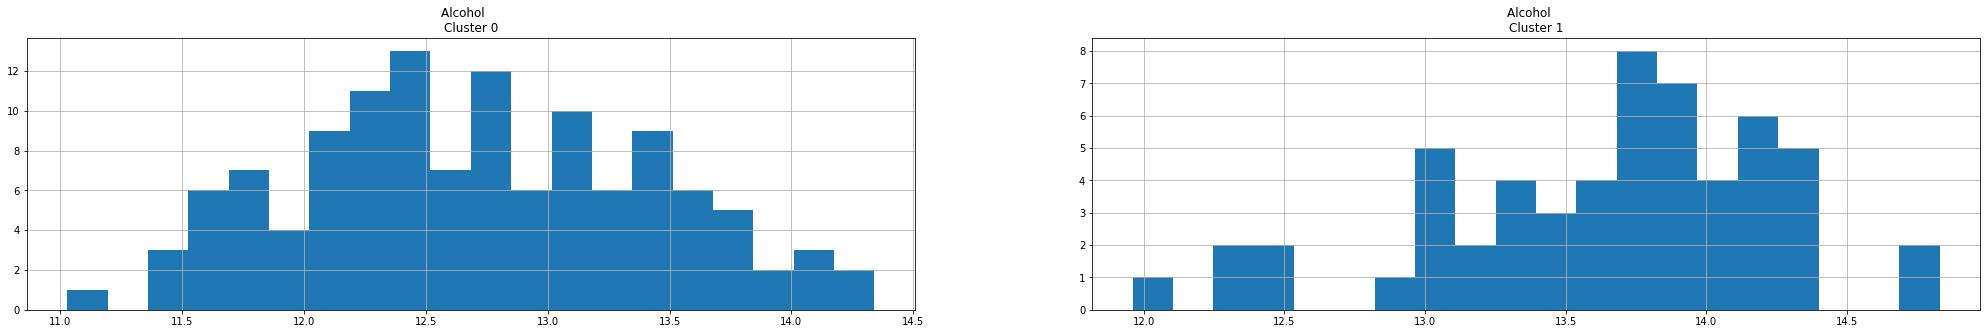

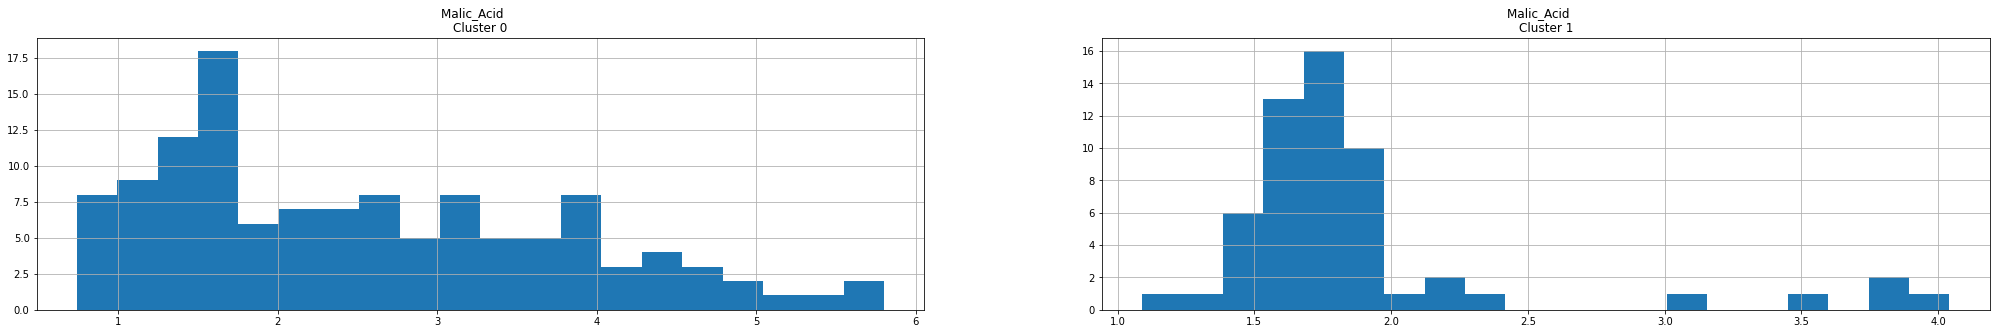

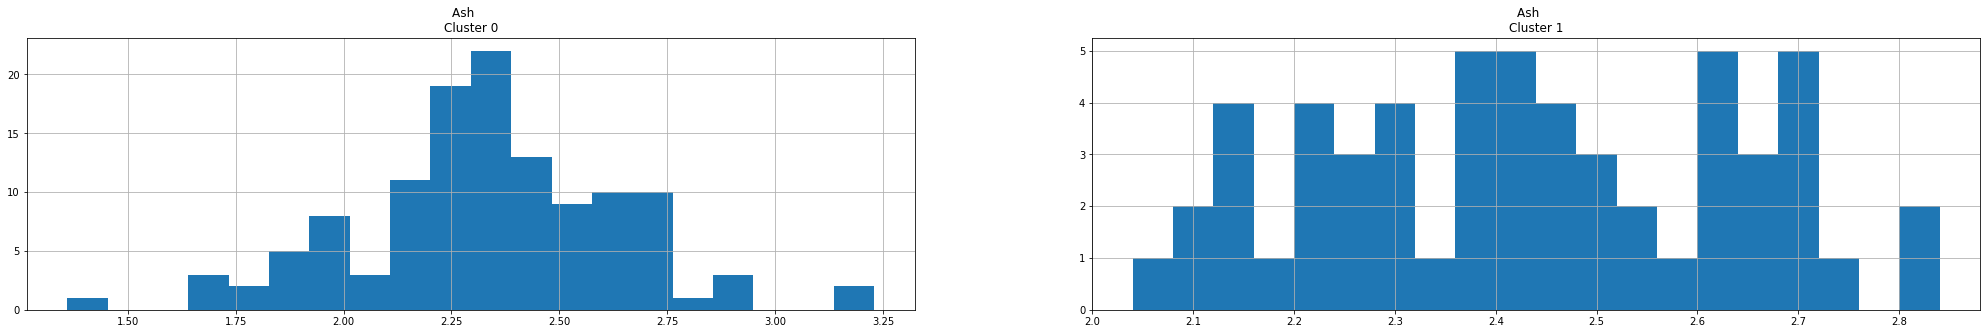

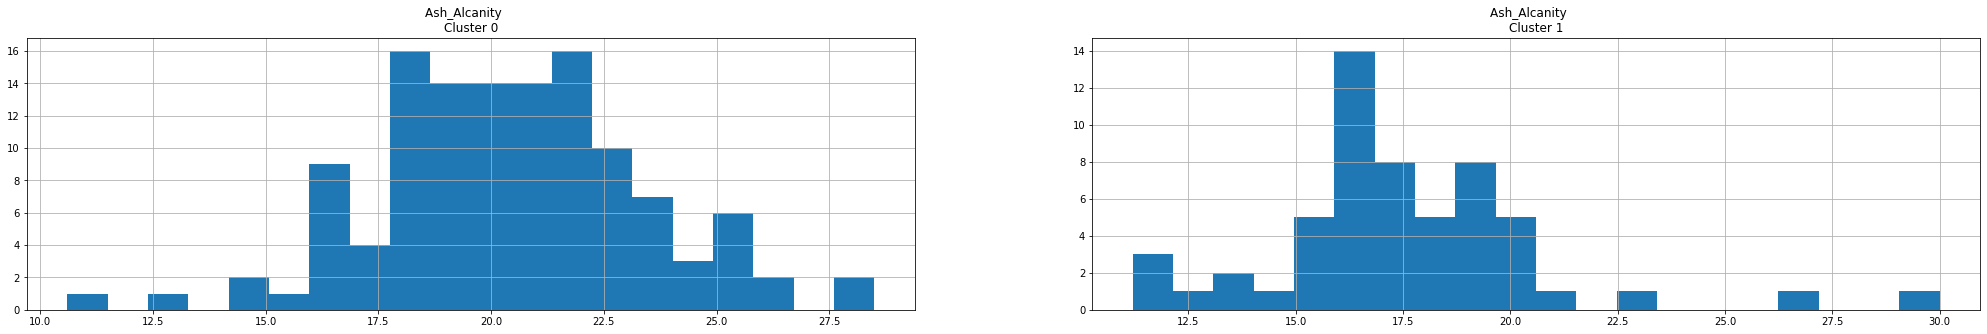

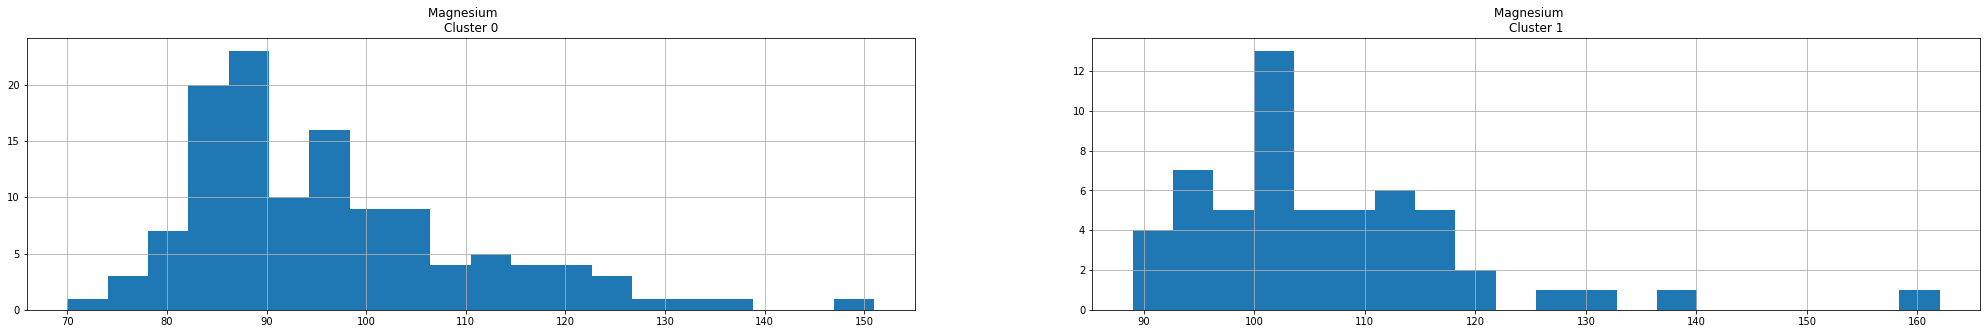

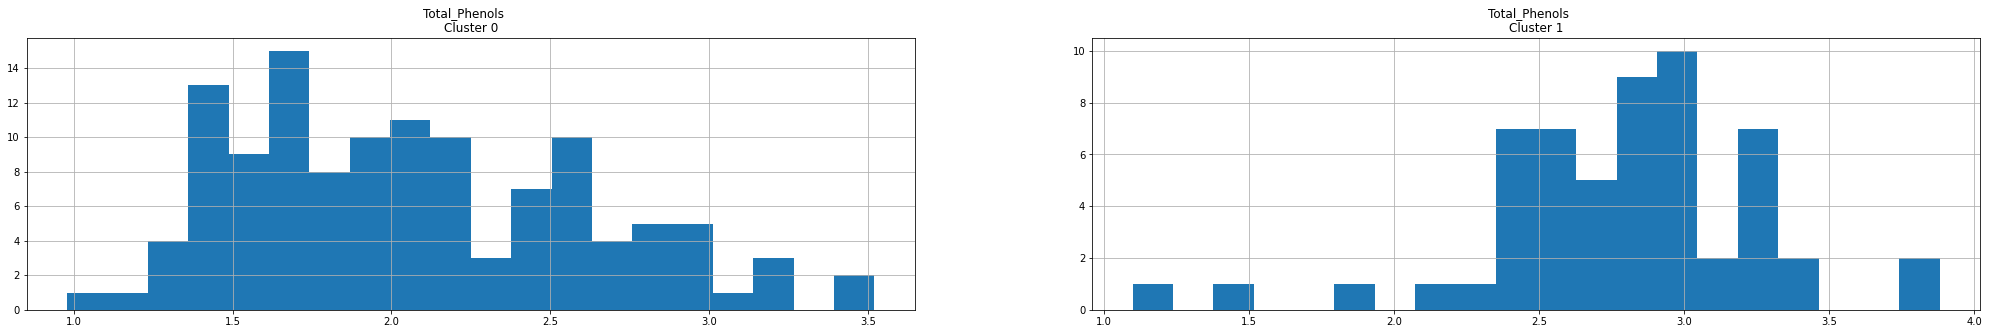

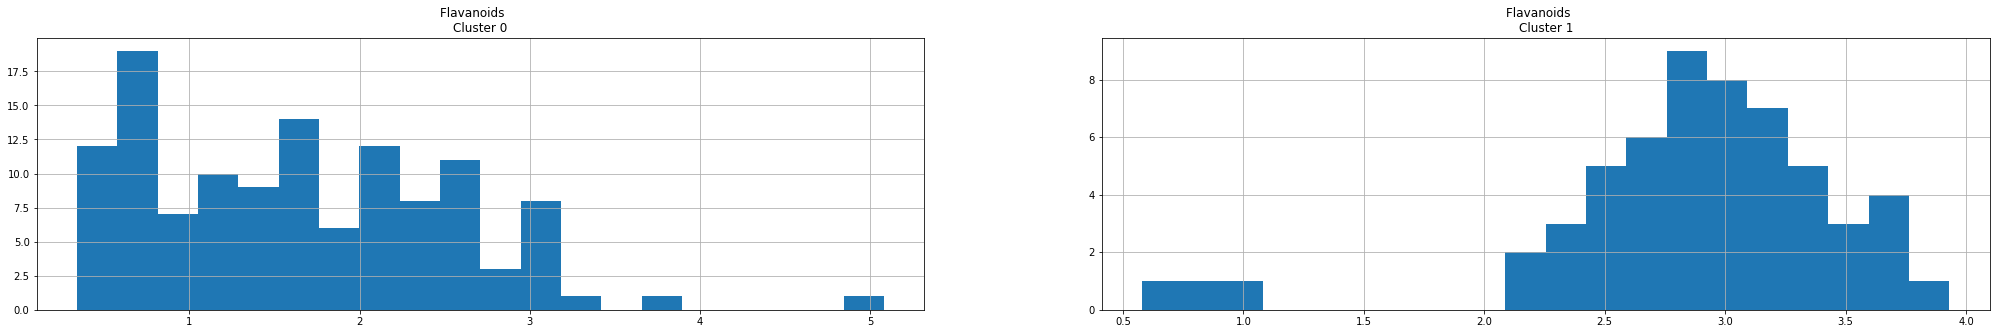

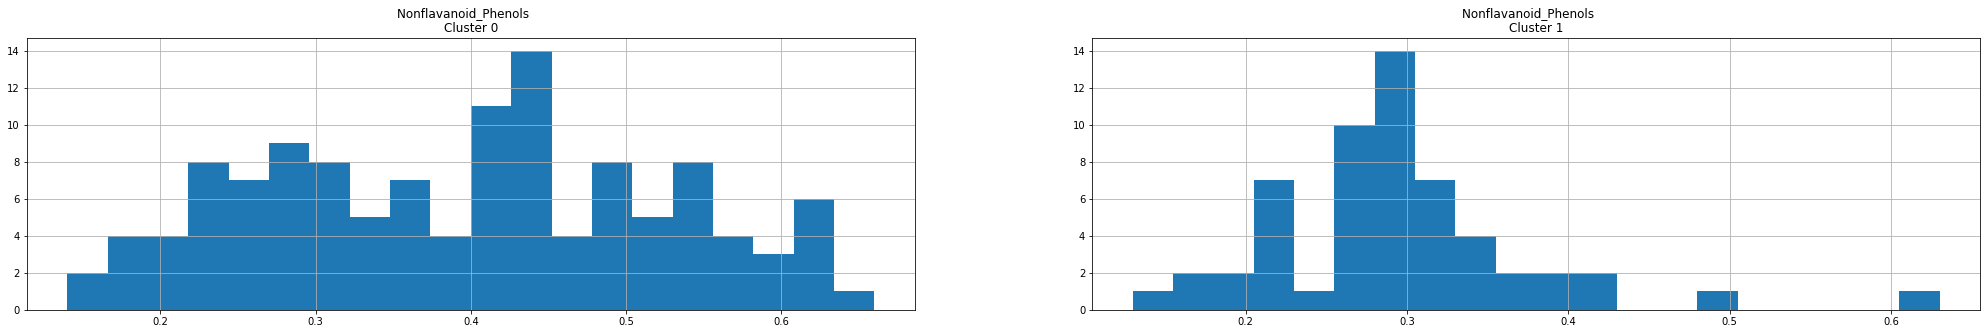

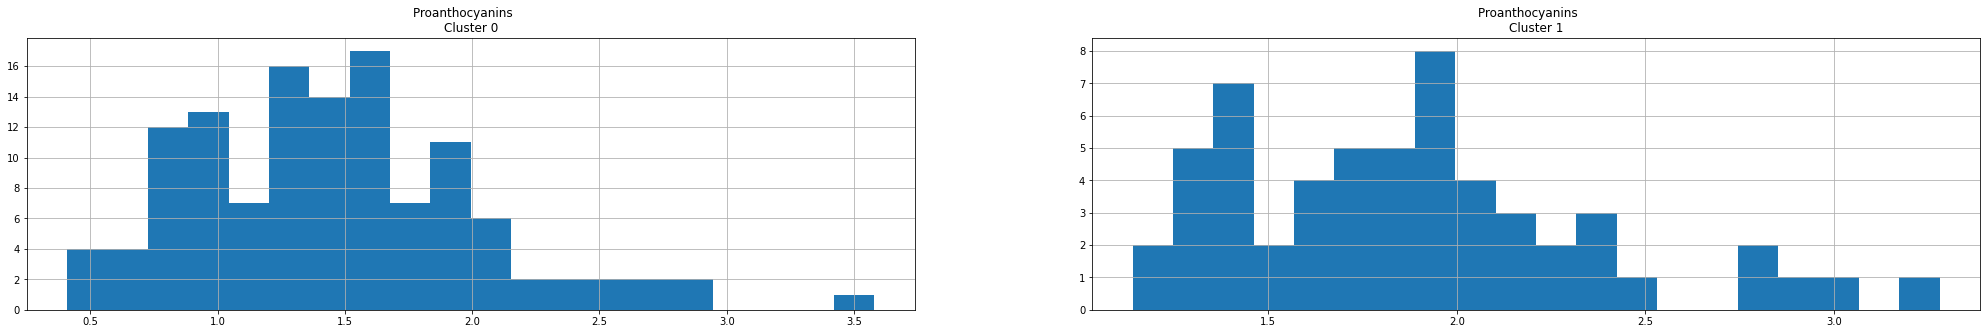

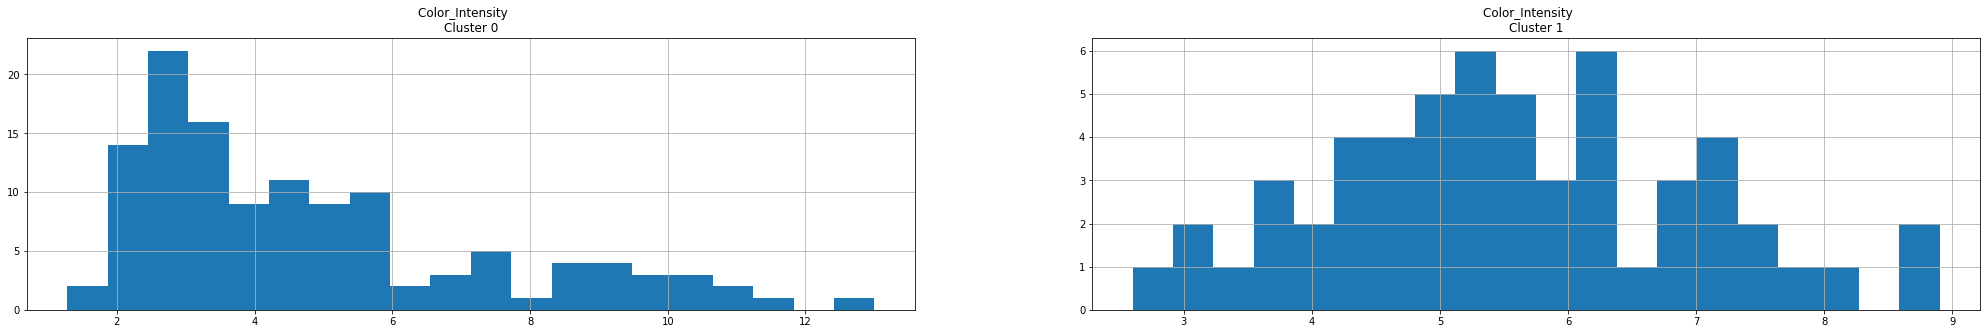

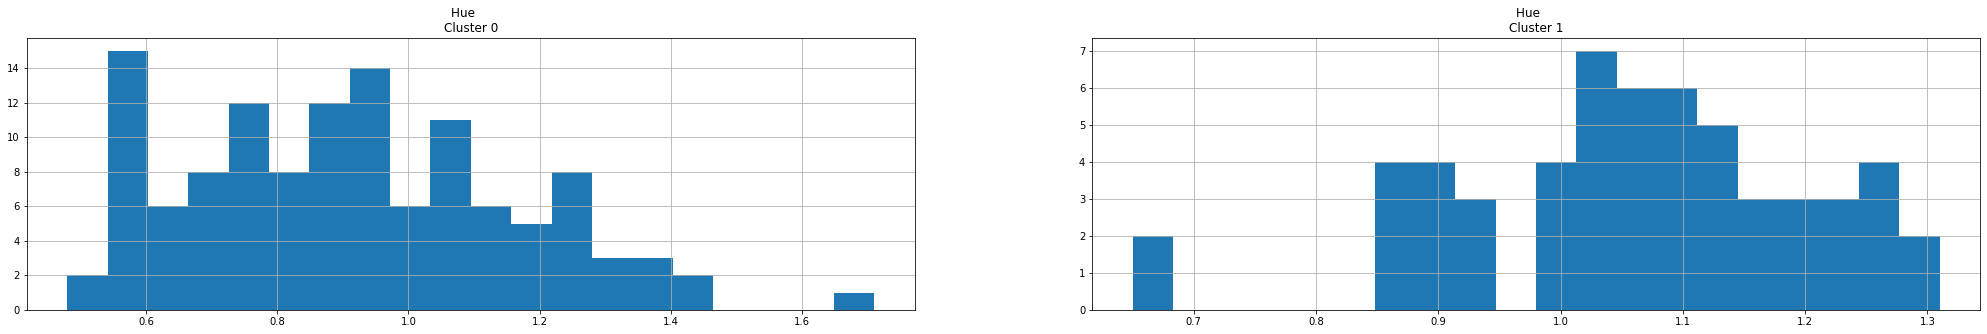

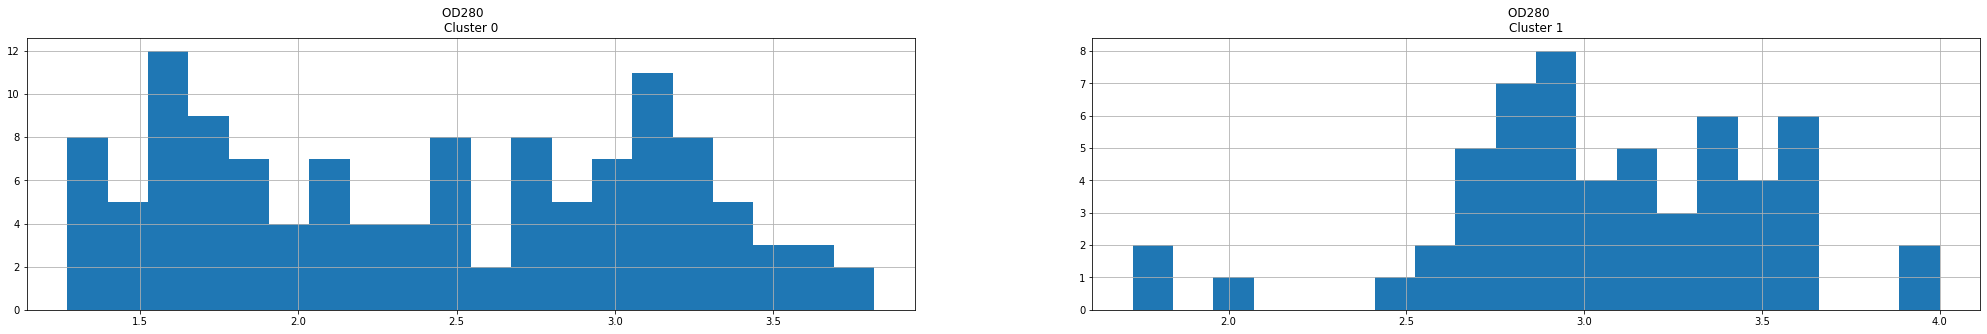

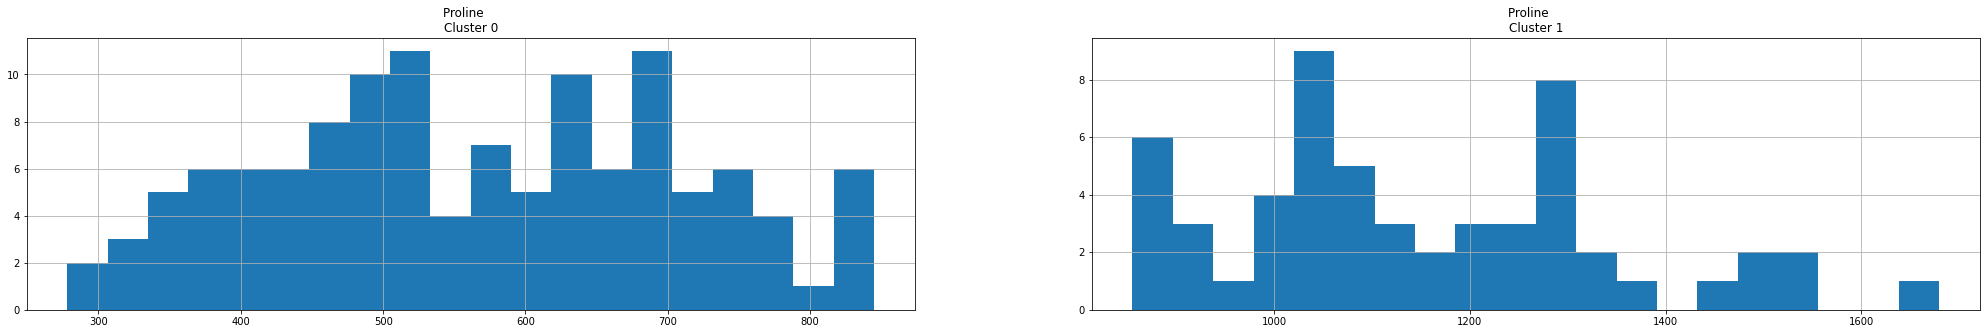

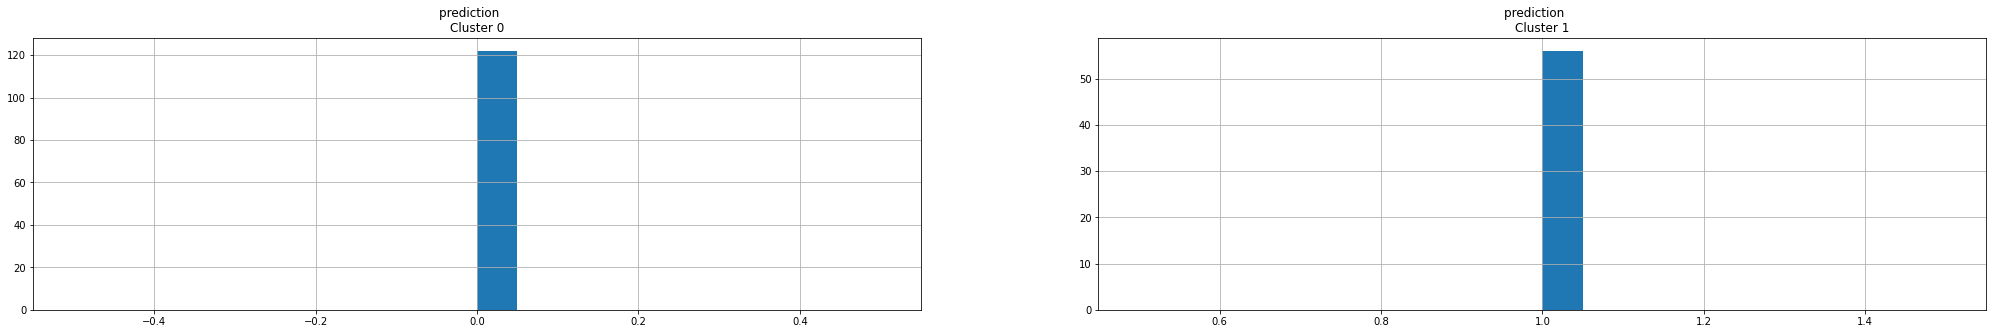

In [52]:
# Visualizamos histogramas para cada cluster 
pandasDF=pandasDF.drop("normalFeatures",axis=1)
pandasDF=pandasDF.drop("features",axis=1)
for i in pandasDF.columns:
    plt.figure(figsize=(35, 5))
    for j in range(2):
        plt.subplot(1, 2, j+1)
        cluster = pandasDF[pandasDF['prediction'] == j]
        cluster[i].hist(bins = 20)
        plt.title('{}    \nCluster {}'.format(i, j))
    plt.show()

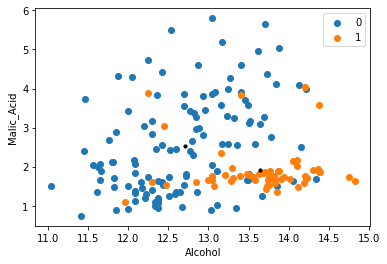

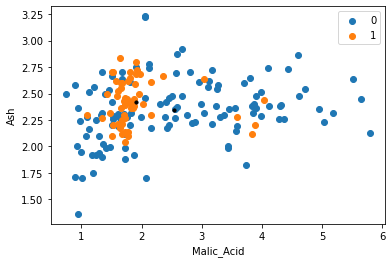

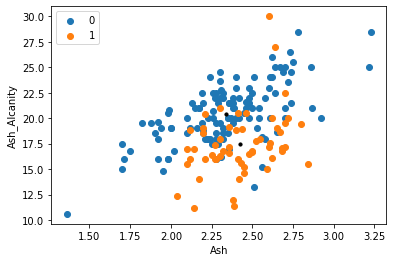

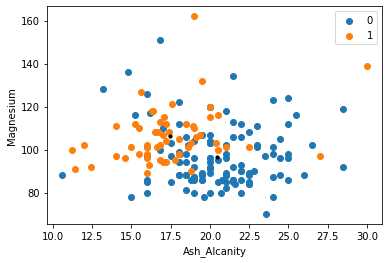

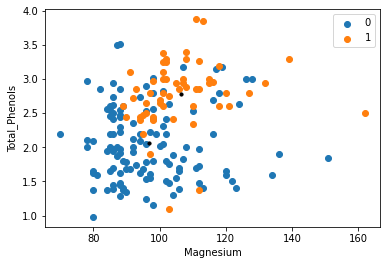

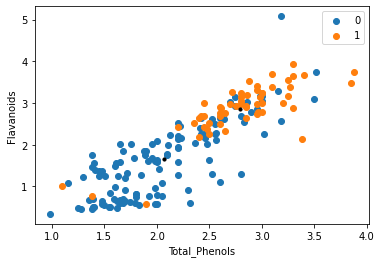

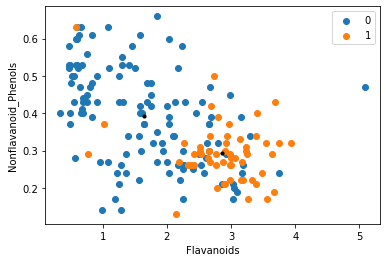

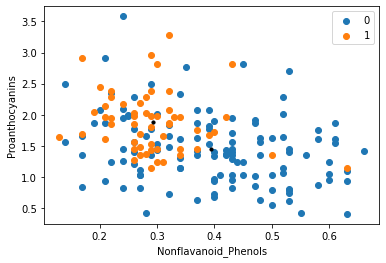

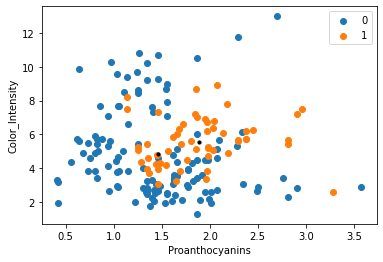

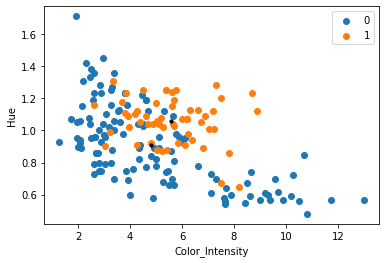

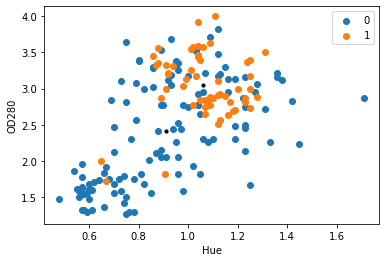

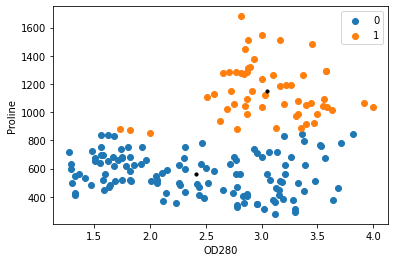

In [62]:
u_labels = [0,1]
for i in range(12):
  feature1 = i
  feature2 = i+1
  #plotting the results:
  for j in u_labels:
    plt.scatter(pandasDF.to_numpy()[pandasDF.prediction.to_numpy() == j , feature1] , pandasDF.to_numpy()[pandasDF.prediction.to_numpy() == j , feature2] , label = j)
  for center in centers:
    plt.scatter(center[feature1], center[feature2], c='k', s=10);
  plt.legend()
  plt.xlabel(pandasDF.columns[feature1])
  plt.ylabel(pandasDF.columns[feature2])
  plt.show()
#En estas gráficas se puede ver como usando practicamente el campo Proline y el campo OD280 se puede identificar la clase del vino